In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib notebook

In [3]:
%matplotlib notebook

NOTES:
this code is written after the file: 
'command_temporal_order_analysis.ipynb'

To Do: 
The Vector Difference between movement-command activity and mean-command activity (move-mean) vs (shuffle-mean)
Individual Neuron Difference (mean, move, shuffle)
Example: for a chosen command and all shuffle distribution, move distribution, dotted line for global mean.
(The example is a tougher scenario... save till end.  That's because we'd like the activity to be for the same command without matching needed)


In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


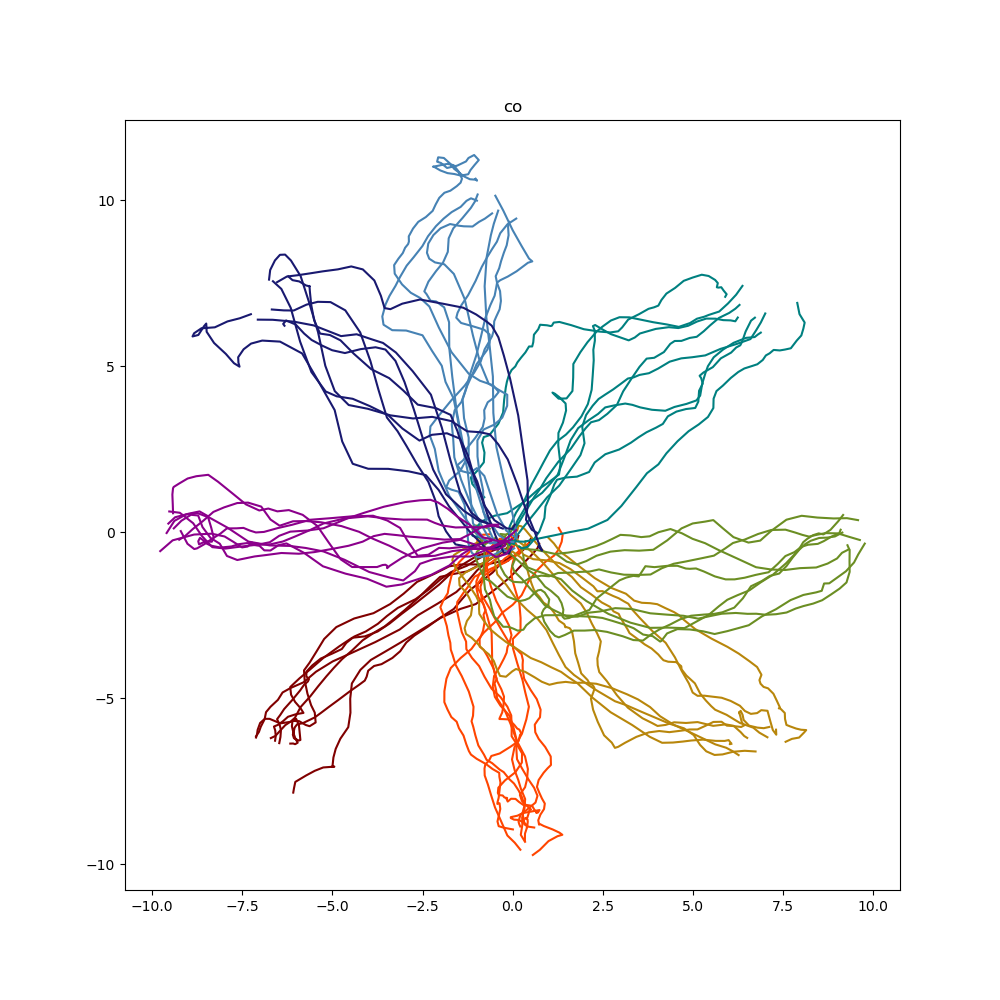

<IPython.core.display.Javascript object>


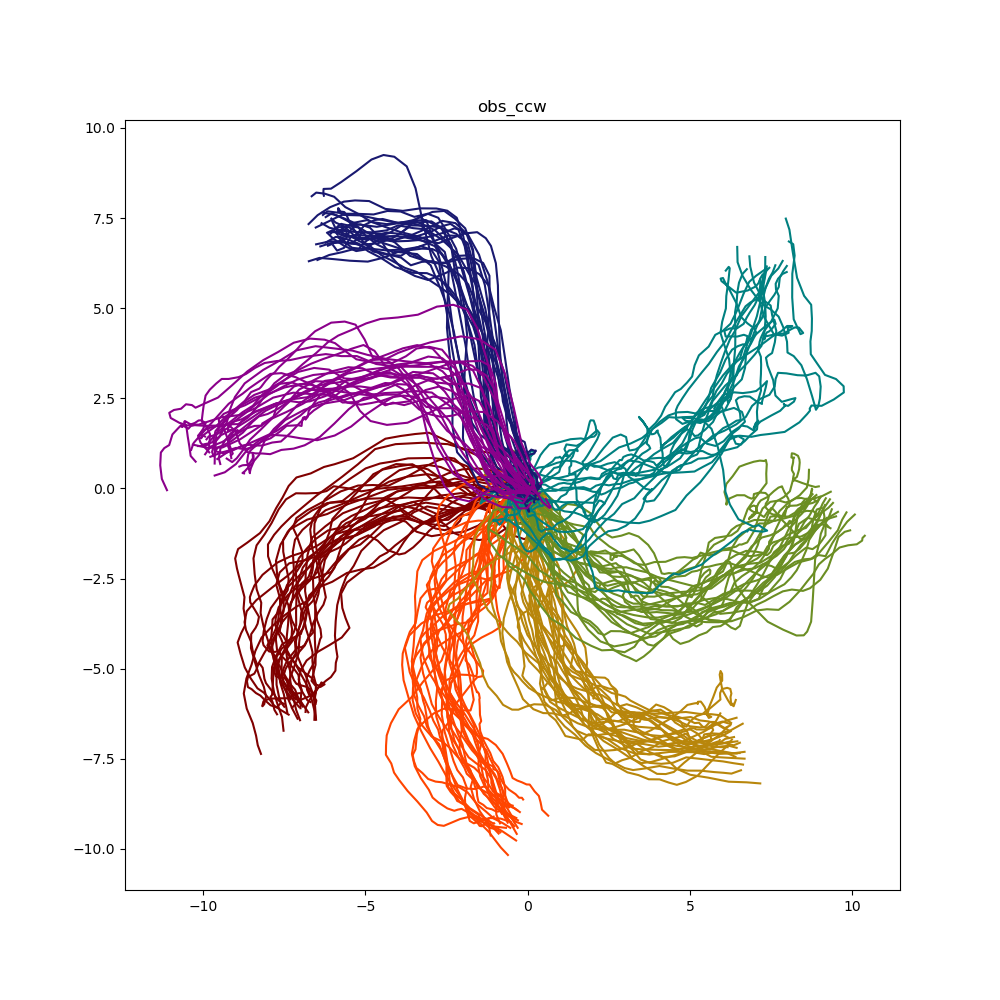

<IPython.core.display.Javascript object>


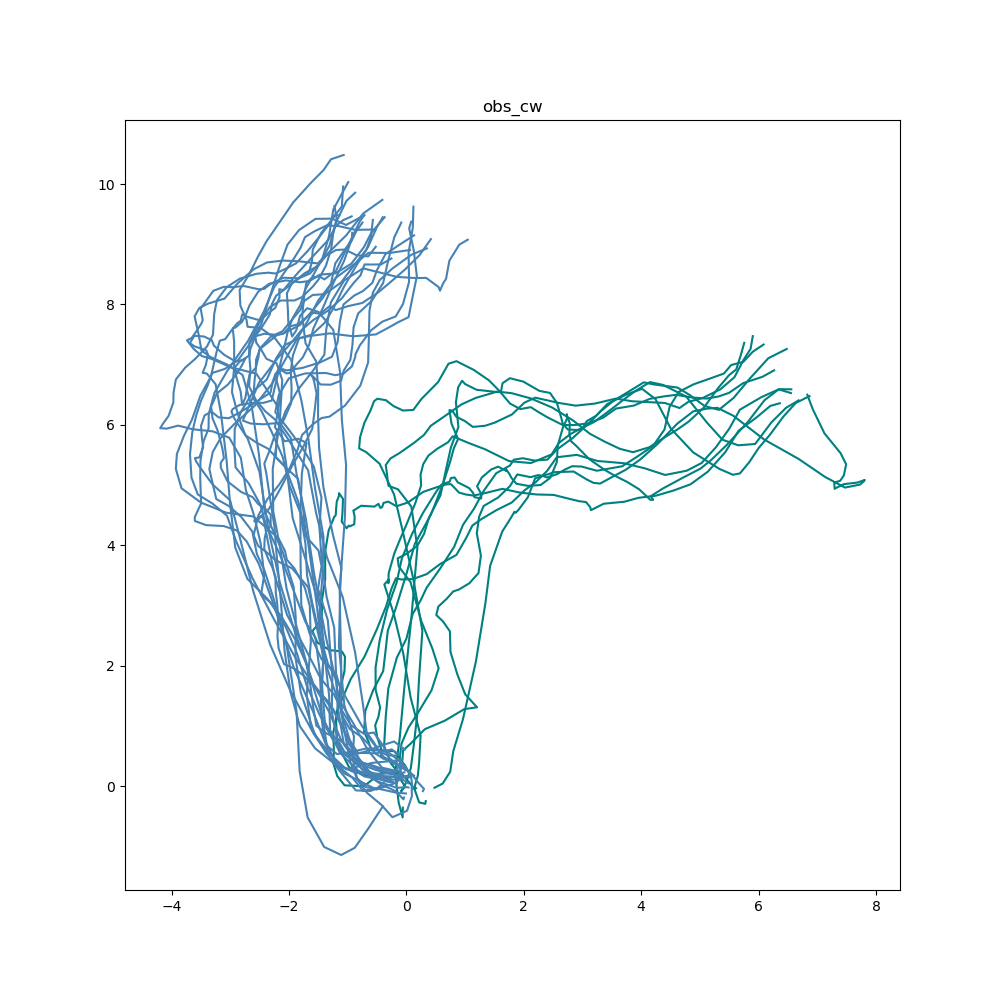

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [7]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)

<IPython.core.display.Javascript object>


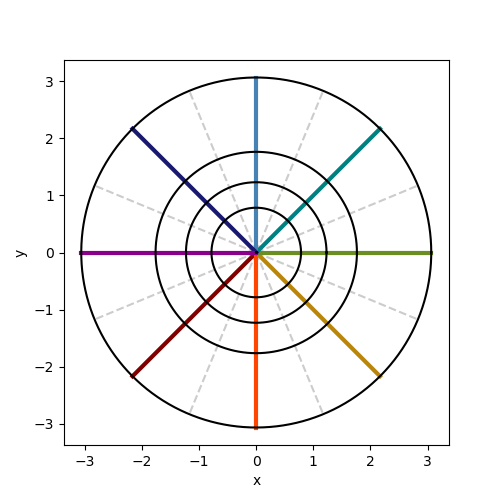

In [8]:
plt.figure(figsize=(5,5))
plot_command_bin()

### Define movement list.  For each command, identify movements which have enough observations of each command.

In [9]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
        
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [10]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for c in c_list: 
    bm = c[0]
    ba = c[1]
    
    cm_dic[c] = []
    cm_dic[c,'num_obs'] = []
    #Loop over movement: 
    for m in move_list:
        sel = \
        (df['target']==m[0]) \
        & (df['task_rot']==m[1]) \
        & (df['bin'] >= bin_buffer) \
        & (df['bin_end'] >= bin_buffer) \
        & (df['u_v_mag_bin'] == bm) \
        & (df['u_v_angle_bin'] == ba)
        num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
        #ASSIGN:
        cm_dic[c,m,'sel'] = sel
        cm_dic[c,m,'num_obs'] = num_obs
        if num_obs >= min_obs:
            cm_dic[c].append(m)
            cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for c in c_list:
    bm = c[0]
    ba = c[1]
    cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
    for m in cm_dic[bm,ba]:
        cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
        | cm_dic[c,m,'sel']
#movement-pool sel wil be useful as the global mean for command-activity.

### For each command, identify the subset of the pool command distribution which matches command mean

In [11]:
#Loop command+movement: 
var = ['u_vx', 'u_vy'] #just to start with 
match_var = var
p_sig = 0.2
max_discard = 150

t_start = timeit.default_timer()

c_list_d = [c_list[10]]
for c in c_list:
    c_idx = df[cm_dic[c,'sel']].index.values
    c_da = bmi_b.df_idx2da(df,c_idx,var)
    cm_list = cm_dic[c]
#     print(cm_list)
#     cm_list_d = [cm_list[0]]
    for m in cm_list:
        cm_idx = df[cm_dic[c,m,'sel']].index.values
        cm_da = bmi_b.df_idx2da(df,cm_idx,var)
        #match distributions:
        d_list=[c_da, cm_da]
        print(c,m)
        success, kept_list, discard_list, df_match, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean_v2(match_var, d_list, p_sig=p_sig, max_iter=max_discard)
        #kept_list: 
        #idx 0: idxs from c_da to keep 
        #idx 1: idxs from cm_da to keep
        
        cm_dic[c,m,'pool_match_idx'] = kept_list[0]
        cm_dic[c,m,'pool_match_success'] = success
        cm_dic[c,m,'pool_match_discard'] = discard_list[0]
        cm_dic[c,m,'pool_match_ttest'] = ttest_r
        cm_dic[c,m,'pool_match_mean'] = mean_r    
        
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed/(60.0*60.0))

((0, 0), (0, 1.1))
matched!
((0, 0), (1, 1.1))
matched!
((0, 0), (2, 1.1))
matched!
((0, 0), (3, 1.1))
matched!
((0, 0), (4, 1.1))
matched!
((0, 1), (0, 1.1))
matched!
((0, 1), (1, 1.1))
matched!
((0, 1), (2, 1.1))
matched!
((0, 1), (3, 1.1))
matched!
((0, 1), (4, 1.1))
matched!
((0, 2), (0, 1.1))
matched!
((0, 2), (1, 0))
matched!
((0, 2), (1, 1.1))
matched!
((0, 2), (2, 0))
matched!
((0, 2), (2, 1.1))
matched!
((0, 2), (3, 1.1))
matched!
((0, 2), (4, 1.1))
matched!
((0, 3), (2, 1.1))
matched!
((0, 3), (3, 1.1))
matched!
((0, 3), (4, 1.1))
matched!
((0, 3), (4, 1.2))
matched!
((0, 3), (5, 1.2))
matched!
((0, 4), (2, 1.1))
matched!
((0, 4), (3, 1.1))
matched!
((0, 4), (4, 1.1))
matched!
((0, 4), (4, 1.2))
matched!
((0, 4), (5, 1.2))
matched!
((0, 5), (2, 1.1))
matched!
((0, 5), (3, 1.1))
matched!
((0, 5), (4, 1.1))
matched!
((0, 5), (4, 1.2))
matched!
((0, 5), (5, 1.2))
matched!
((0, 6), (3, 1.1))
matched!
((0, 6), (4, 1.1))
matched!
((0, 6), (5, 1.2))
matched!
((0, 7), (3, 1.1))
match

KeyboardInterrupt: 

### Shuffle movement+time label of each command observation, to serve as a control

In [327]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
t_start = timeit.default_timer()
num_shuffle = 1000
for c in c_list:
    for m in cm_dic[c]:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        num_obs = cm_dic[c,m,'num_obs']
        shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
        for s in range(num_shuffle):
            shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
        #ASSIGN:
        cm_dic[c,m,'shuffle_mat'] = shuffle_mat
t_elapsed = timeit.default_timer()-t_start            

### Implement the analysis of comparing command-activity:

In [39]:
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]

In [366]:
#let's calculate the true vector diff vs shuffle vector diff:
#true mean, shuffle mean, pool-match mean
t_start = timeit.default_timer()
n_list = ['n_'+str(i) for i in range(num_neurons)]
mean_var = copy.copy(n_list)

num_shuffle = 1000

for c in c_list:
    for m in cm_dic[c]:
        print(c,m)
        #POOL:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        mu_c = df.loc[c_idxs, mean_var].mean()
        
        #MOVE:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        mu_cm = df.loc[cm_idxs, mean_var].mean()
        
        #SHUFFLE:
        nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
        s_mean = xr.DataArray(nan_mat, 
                          coords={'v':mean_var,'shuffle':range(num_shuffle)},
                          dims=['v','shuffle'])
        for s in range(num_shuffle):
            s_idxs = cm_dic[c,m,'shuffle_mat'][:,s]
            mu_s = df.loc[s_idxs, mean_var].mean()
            s_mean.loc[:,s] = mu_s
        
        #ASSIGN:
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
        cm_dic[c,m,'n_c'] = mu_c
        cm_dic[c,m,'n_cm'] = mu_cm
        cm_dic[c,m,'n_s'] = s_mean
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
        

((0, 0), (0, 1.1))
((0, 0), (1, 1.1))
((0, 0), (2, 1.1))
((0, 0), (3, 1.1))
((0, 0), (4, 1.1))
((0, 1), (0, 1.1))
((0, 1), (1, 1.1))
((0, 1), (2, 1.1))
((0, 1), (3, 1.1))
((0, 1), (4, 1.1))
((0, 2), (0, 1.1))
((0, 2), (1, 0))
((0, 2), (1, 1.1))
((0, 2), (2, 0))
((0, 2), (2, 1.1))
((0, 2), (3, 1.1))
((0, 2), (4, 1.1))
((0, 3), (2, 1.1))
((0, 3), (3, 1.1))
((0, 3), (4, 1.1))
((0, 3), (4, 1.2))
((0, 3), (5, 1.2))
((0, 4), (2, 1.1))
((0, 4), (3, 1.1))
((0, 4), (4, 1.1))
((0, 4), (4, 1.2))
((0, 4), (5, 1.2))
((0, 5), (2, 1.1))
((0, 5), (3, 1.1))
((0, 5), (4, 1.1))
((0, 5), (4, 1.2))
((0, 5), (5, 1.2))
((0, 6), (3, 1.1))
((0, 6), (4, 1.1))
((0, 6), (5, 1.2))
((0, 7), (3, 1.1))
((0, 7), (4, 1.1))
((1, 0), (0, 1.1))
((1, 0), (1, 0))
((1, 0), (1, 1.1))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1), (0, 1.1))
((1, 1), (1, 0))
((1, 1), (1, 1.1))
((1, 1), (2, 1.1))
((1, 1), (3, 1.1))
((1, 1), (4, 1.1))
((1, 2), (0, 1.1))
((1, 2), (1, 0))
((1, 2), (1, 1.1))
((1, 2), (2, 0))
((1, 

### Calculate which command-movement activity is sig different from command-pool activity

In [368]:
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        #Vec Diff: 
        cm_dic[c,m,'n_diff_true'] = cm_dic[c,m,'n_c'] - cm_dic[c,m,'n_cm']
        n_c_rep = np.array(cm_dic[c,m,'n_c'])[...,None]
        cm_dic[c,m,'n_diff_s'] = n_c_rep-cm_dic[c,m,'n_s']
        
        #Norm Diff: 
        cm_dic[c,m,'n_diff_norm_true'] = np.linalg.norm(cm_dic[c,m,'n_diff_true'], axis=0)
        cm_dic[c,m,'n_diff_norm_s'] = np.linalg.norm(cm_dic[c,m,'n_diff_s'], axis=0)
        

### Save Results

In [ ]:
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
save_path = os.path.join(save_dir, 'mean_analysis_shuffle1000.pkl')

with open(save_path, 'wb') as f: 
    data = pickle.dump(cm_dic, f, protocol=pickle.HIGHEST_PROTOCOL)


### Load results

In [12]:
# Test load the results
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
save_path = os.path.join(save_dir, 'mean_analysis_shuffle1000.pkl')
with open(save_path, 'rb') as f: 
    test = pickle.load(f)
np.sum(np.array(test['p'])<=0.05)/float(len(test['p']))  


#if you want to use the loaded results: 
use_loaded_results = True
if use_loaded_results:
    cm_dic = test

### Stats

### Fraction of significant command-movements

In [14]:
num_shuffle=1000

<IPython.core.display.Javascript object>


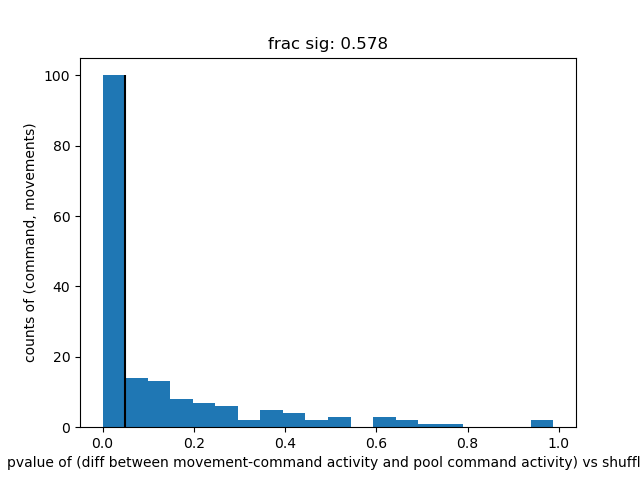

Text(0,0.5,'counts of (command, movements)')

In [15]:
#Count how many shuffle diffs are greater than true diff, and divide by number of shuffles for pval
#TODO: Make a data frame for each (c,m) to store the results
cm_dic['p'] = []
for c in c_list:
    for m in cm_dic[c]:
        num = np.sum((cm_dic[c,m,'n_diff_norm_s']-cm_dic[c,m,'n_diff_norm_true'])>0)
        p = float(num)/num_shuffle
        cm_dic[c,m,'p'] = p
        cm_dic['p'].append(p)        
            
p_sig =0.05
frac_sig = float(np.sum(np.array(cm_dic['p'])<=p_sig))/len(cm_dic['p'])

plt.figure()
n,bins,patch=plt.hist(cm_dic['p'],20)
plt.vlines(0.05, 0, n.max() )
plt.title('frac sig: ' + str(round(frac_sig,4)))
plt.xlabel('pvalue of (diff between movement-command activity and pool command activity) vs shuffle')
plt.ylabel('counts of (command, movements)')

### Fraction of significant (neuron-command-movements) and (neurons)

In [16]:
cm_dic[c,m,'n_c']/sample_period

n_0     12.329843
n_1      5.104712
n_2      0.209424
n_3      0.392670
n_4     17.958115
n_5     26.596859
n_6     17.984293
n_7      3.272251
n_8      0.261780
n_9      0.000000
n_10     0.130890
n_11    19.136126
n_12     0.602094
n_13     0.183246
n_14    12.329843
n_15    19.581152
n_16     6.544503
n_17     7.905759
n_18    13.324607
n_19     6.518325
n_20     4.554974
n_21    16.518325
n_22    17.277487
n_23    18.036649
n_24     5.759162
n_25     6.151832
n_26    15.104712
n_27    22.460733
n_28    10.680628
n_29     5.602094
n_30    13.821990
n_31    15.994764
n_32    23.350785
n_33    11.727749
n_34     6.910995
n_35    18.298429
n_36    19.712042
n_37    15.916230
n_38    24.214660
n_39    22.748691
n_40     1.151832
n_41    72.801047
n_42     6.151832
n_43     8.926702
dtype: float64

In [17]:
#(neuron-command-movements)

#(neurons sig modulated for at least one command-movement)
# rn = []
num_ncm = 0
num_cm = 0
num_sig_ncm = 0
n_num_sig_cm = pd.DataFrame(data=np.ones((1,44)),columns=n_list)
p_sig = 0.05

sample_period = 0.1
min_fr = 0.5

for c in c_list:
    for m in cm_dic[c]:
        true = np.abs(cm_dic[c,m,'n_diff_true'])
        s_mat = np.abs(cm_dic[c,m,'n_diff_s'])
        mat_t_minus_s = np.array(true).reshape((-1,1))-s_mat
        num = (mat_t_minus_s<0).sum(axis=1)
        pn = num/float(num_shuffle)
        
        #set to nan if the command mean is too low: 
#         pn.loc[(cm_dic[c,m,'n_c'] <= min_fr)]= np.nan
        cm_dic[c,m,'p_n'] = pn
        
        
        
        cm_dic[c,m,'num_sig_n'] = np.sum((pn<p_sig)&(cm_dic[c,m,'n_c']>=min_fr))
        
        num_valid_neurons = np.sum((cm_dic[c,m,'n_c']>=min_fr))
        num_ncm += num_valid_neurons #num_neurons
        num_cm += 1
        num_sig_ncm += cm_dic[c,m,'num_sig_n']
        
        n_num_sig_cm += (pn<p_sig)&(cm_dic[c,m,'n_c']>=min_fr)
frac_sig_ncm = float(num_sig_ncm)/num_ncm

In [18]:
#Fraction of significant (neuron,command,movement):
print(frac_sig_ncm)

0.13229070837166512


In [88]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\command_activity_diff'

        n_0       n_1      n_2      n_3       n_4       n_5       n_6  \
0  0.219653  0.052023  0.00578  0.00578  0.144509  0.104046  0.080925   

       n_7      n_8      n_9  ...      n_34      n_35      n_36      n_37  \
0  0.00578  0.00578  0.00578  ...  0.011561  0.080925  0.219653  0.196532   

       n_38      n_39      n_40      n_41      n_42      n_43  
0  0.283237  0.127168  0.254335  0.300578  0.236994  0.196532  

[1 rows x 44 columns]


<IPython.core.display.Javascript object>


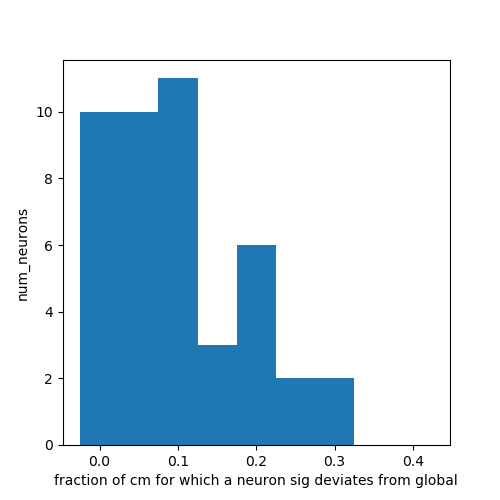

In [20]:
#For each neuron, for what fraction of (command,movements) does it sig deviate from command-global? 
#TODO: only evaluate for valid neurons... for now this hist includes neurons which don't sig deviate because they have too low of fr


fig_name = 'hist_frac_cm_that_n_is_sig'
save_bool = False

n_frac_sig_cm = n_num_sig_cm/float(num_cm)
print(n_frac_sig_cm)


bin_e = np.arange(0,0.5,0.05)-0.025

plt.figure(figsize=(5,5))
_=plt.hist(n_frac_sig_cm,bins=bin_e)
plt.xlabel('fraction of cm for which a neuron sig deviates from global')
plt.ylabel('num_neurons')

if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name))
        

In [21]:
n_num_sig_cm

n_0  n_1  n_2  n_3   n_4   n_5   n_6  n_7  n_8  n_9  ...  n_34  n_35  \
0  38.0  9.0  1.0  1.0  25.0  18.0  14.0  1.0  1.0  1.0  ...   2.0  14.0   

   n_36  n_37  n_38  n_39  n_40  n_41  n_42  n_43  
0  38.0  34.0  49.0  22.0  44.0  52.0  41.0  34.0  

[1 rows x 44 columns]

In [22]:
#Fraction of neurons which are sig for at least one c-m:
n_frac_sig = np.sum(n_num_sig_cm>0,axis=1)/num_neurons
print(n_frac_sig)

0    1.0
dtype: float64


In [23]:
#Get the observations of data
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]

### Hist/Scatter mean diffs 

In [31]:
num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

### Population vector

In [32]:
#Metric for the whole day: 
#Compute for true data and average over shuffle (?)
#1) change from global mean
#for each command-movement, do: norm(global_mean-data_mean)
#2) frac change from global mean
#for each command-movement, do: norm(global_mean-data_mean)/(norm(global_mean))

In [33]:
columns = \
['shuffle_diff_norm', 'true_diff_norm', 'global_norm',\
 'command_idx', 'movement_idx',  'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']

df_test = pd.DataFrame(index=[0], columns=columns)

In [35]:
#Make dataframe of results: 
columns = \
['shuffle_diff_norm', 'true_diff_norm', 'global_norm', 'true_frac_diff_norm', 'shuffle_frac_diff_norm', \
 'command_idx', 'movement_idx',  'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']
p_sig = 0.05
r = []

for c in c_list:
    for m in cm_dic[c]:
        diff_df = pd.DataFrame(index=[0],columns=columns)
        
        #RESULTS:
        diff_df.loc[0,'true_diff_norm'] = cm_dic[c,m,'n_diff_norm_true']
        diff_df.loc[0,'shuffle_diff_norm'] = cm_dic[c,m,'n_diff_norm_s'].mean()
        
        diff_df.loc[0,'global_norm'] = np.linalg.norm(cm_dic[c,m,'n_c'])
        diff_df.loc[0,'true_frac_diff_norm'] = cm_dic[c,m,'n_diff_norm_true']/diff_df.loc[0,'global_norm']
        diff_df.loc[0,'shuffle_frac_diff_norm'] = cm_dic[c,m,'n_diff_norm_s'].mean()/diff_df.loc[0,'global_norm']
        
        #RELATED VAR:
        diff_df.loc[0,'command_idx'] = c2idx[c]
        diff_df.loc[0,'movement_idx'] = m2idx[m]
        diff_df.loc[0,'u_v_mag_bin'] = c[0]
        diff_df.loc[0,'u_v_angle_bin'] = c[1]
        diff_df.loc[0,'p'] = cm_dic[c,m,'p']
        diff_df.loc[0,'sig'] = cm_dic[c,m,'p']<=p_sig
        
        r.append(diff_df)

r = pd.concat(r,ignore_index=True)

<IPython.core.display.Javascript object>


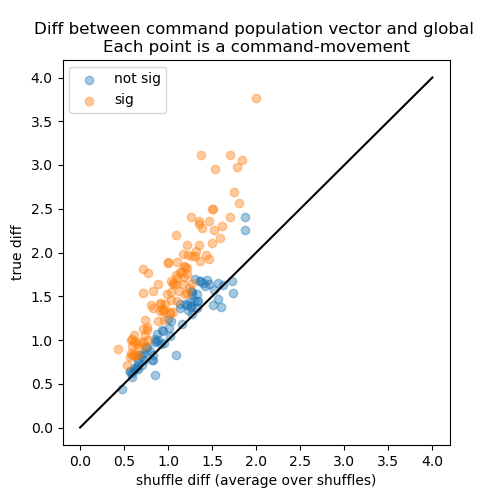

In [36]:
fig_name = 'scatter_vector_diff_true_vs_shuffle'
save_bool = False

# s_nsig = r.loc[:,'shuffle_diff_norm']
# d_nsig = r.loc[:,'true_diff_norm']

bm_sel = r.loc[:, 'u_v_mag_bin'] >=0
extra_sel = bm_sel

sel = (r.loc[:,'sig']==0)&extra_sel
s_nsig = r.loc[sel,'shuffle_diff_norm']
d_nsig = r.loc[sel,'true_diff_norm']

sel = (r.loc[:,'sig']==1)&extra_sel
s_sig = r.loc[sel,'shuffle_diff_norm']
d_sig = r.loc[sel,'true_diff_norm']


plt.figure(figsize=(5,5))
# plt.scatter(s,d,alpha=0.4)
plt.scatter(s_nsig,d_nsig,alpha=0.4, label='not sig')
plt.scatter(s_sig,d_sig,alpha=0.4, label='sig')
plt.legend()
plt.plot([0,4], [0,4],color='k')
plt.xlabel('shuffle diff (average over shuffles)')
plt.ylabel('true diff')
plt.title('Diff between command population vector and global \nEach point is a command-movement')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


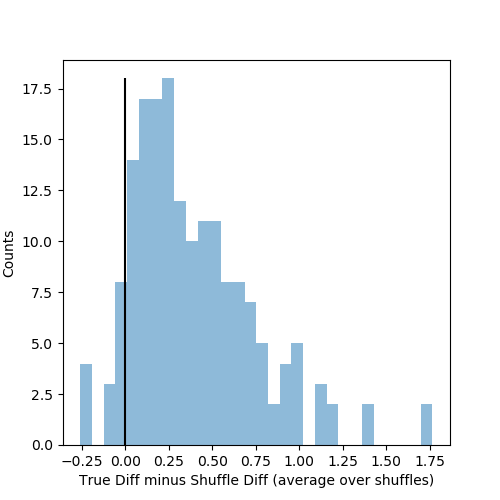

<IPython.core.display.Javascript object>


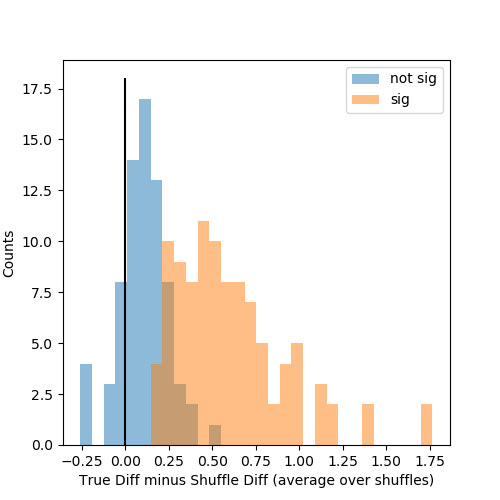

In [37]:
#Histogram of differences
#All and just significant: 


fig_name = 'hist_vector_diff_true_minus_shuffle'
save_bool = False

#ALL DATA:
s = r.loc[:,'shuffle_diff_norm']
d = r.loc[:,'true_diff_norm']
diff_df = d-s
diff=list(d-s)
plt.figure(figsize=(5,5))
n_all,bins,_ = plt.hist(diff,bins=30,alpha=0.5)
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


fig_name = 'hist_vector_diff_true_minus_shuffle_sig'
save_bool = True
        
#NOT SIG and SIG:
sel = (r.loc[:,'sig']==0)
s_nsig = r.loc[sel,'shuffle_diff_norm']
d_nsig = r.loc[sel,'true_diff_norm']
diff_nsig=list(d_nsig-s_nsig)

sel = (r.loc[:,'sig']==1)
s_sig = r.loc[sel,'shuffle_diff_norm']
d_sig = r.loc[sel,'true_diff_norm']
diff_sig = list(d_sig-s_sig)


# bin_e = np.linspace(0,4,41)
plt.figure(figsize=(5,5))
# n_all,bins,_ = plt.hist(diff,bins=20,alpha=0.5)
ig = plt.hist(diff_nsig,bins=bins,alpha=0.5,label='not sig')
ig = plt.hist(diff_sig,bins=bins,alpha=0.5,label='sig')
plt.legend()
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


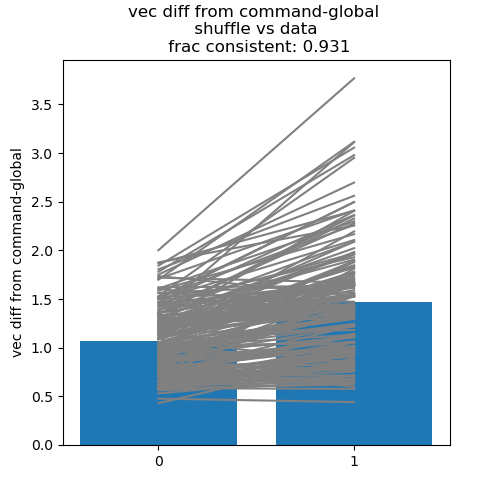

In [38]:
#BAR PLOT: 
fig_name = 'bar_vector_diff_true_vs_shuffle'
save_bool = False

s = np.array(r.loc[:,'shuffle_diff_norm'])
d = np.array(r.loc[:,'true_diff_norm'])
d_plt = np.concatenate((s.reshape(-1,1), d.reshape(-1,1)),axis=1).T

# If you want to see negative vs positive data points:
pos_sel = (d_plt[1,:]-d_plt[0,:])>=0
d_plt_pos = d_plt[:,pos_sel]
neg_sel = (d_plt[1,:]-d_plt[0,:])<0
d_plt_neg = d_plt[:,neg_sel]

frac_consistent = float(sum(pos_sel))/len(d)
#number of data points obeying the trend

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt_pos,color=0.5*np.ones(3))
# _=plt.plot(d_plt_neg,color='r')

_=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])

_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])
plt.ylabel('vec diff from command-global')
plt.title('vec diff from command-global \n shuffle vs data \n frac consistent: ' + str(round(frac_consistent,3)))
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


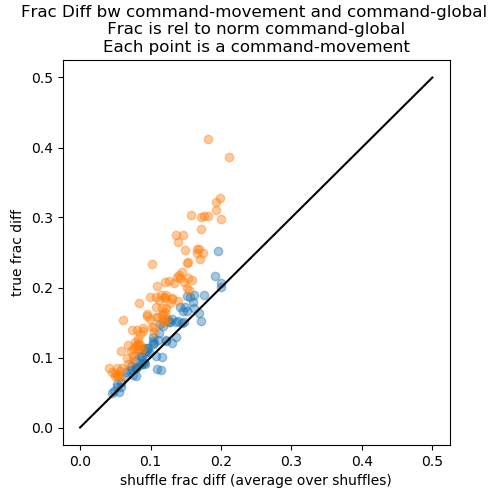

In [39]:
fig_name = 'scatter_vector_frac_diff_true_vs_shuffle'
save_bool = False

# s = r.loc[:,'shuffle_frac_diff_norm']
# d = r.loc[:,'true_frac_diff_norm']

sel = r.loc[:,'sig']==0
s_nsig = r.loc[sel,'shuffle_frac_diff_norm']
d_nsig = r.loc[sel,'true_frac_diff_norm']

sel = r.loc[:,'sig']==1
s_sig = r.loc[sel,'shuffle_frac_diff_norm']
d_sig = r.loc[sel,'true_frac_diff_norm']


plt.figure(figsize=(5,5))
# plt.scatter(s,d,alpha=0.4)
plt.scatter(s_nsig,d_nsig,alpha=0.4, label='not sig')
plt.scatter(s_sig,d_sig,alpha=0.4, label='sig')

plt.plot([0, 0.5], [0,0.5],color='k')
plt.xlabel('shuffle frac diff (average over shuffles)')
plt.ylabel('true frac diff')
plt.title('Frac Diff bw command-movement and command-global \n Frac is rel to norm command-global \nEach point is a command-movement')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


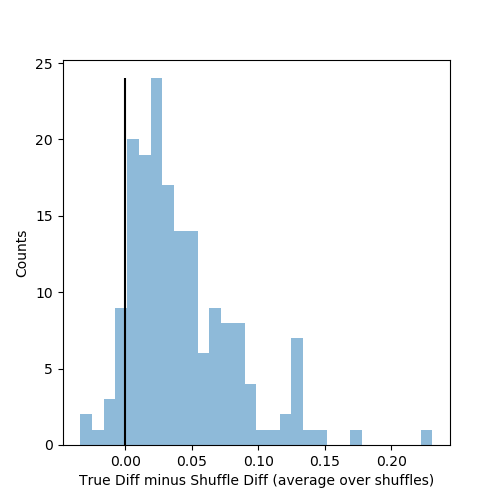

<IPython.core.display.Javascript object>


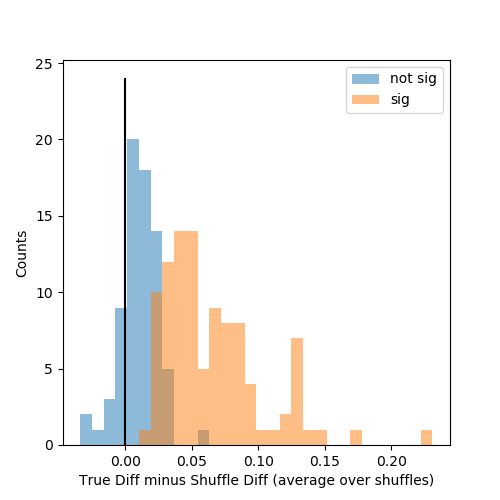

In [40]:
#Histogram of frac differences
#All and just significant: 

#-----------------------------------------------------------------------
fig_name = 'hist_vector_frac_diff_true_minus_shuffle'
save_bool = False

#ALL DATA:
s = r.loc[:,'shuffle_frac_diff_norm']
d = r.loc[:,'true_frac_diff_norm']
diff_df = d-s
diff=list(d-s)
plt.figure(figsize=(5,5))
n_all,bins,_ = plt.hist(diff,bins=30,alpha=0.5)
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


#-----------------------------------------------------------------------
fig_name = 'hist_vector_frac_diff_true_minus_shuffle_sig'
save_bool = False
        
#NOT SIG and SIG:
sel = (r.loc[:,'sig']==0)
s_nsig = r.loc[sel,'shuffle_frac_diff_norm']
d_nsig = r.loc[sel,'true_frac_diff_norm']
diff_nsig=list(d_nsig-s_nsig)

sel = (r.loc[:,'sig']==1)
s_sig = r.loc[sel,'shuffle_frac_diff_norm']
d_sig = r.loc[sel,'true_frac_diff_norm']
diff_sig = list(d_sig-s_sig)

# bin_e = np.linspace(0,4,41)
plt.figure(figsize=(5,5))
# n_all,bins,_ = plt.hist(diff,bins=20,alpha=0.5)
ig = plt.hist(diff_nsig,bins=bins,alpha=0.5,label='not sig')
ig = plt.hist(diff_sig,bins=bins,alpha=0.5,label='sig')
plt.legend()
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


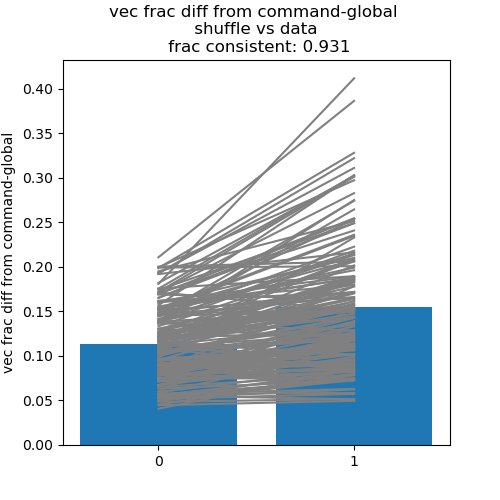

In [41]:
#BAR PLOT: 
fig_name = 'bar_vector_frac_diff_true_vs_shuffle'
save_bool = False

s = np.array(r.loc[:,'shuffle_frac_diff_norm'])
d = np.array(r.loc[:,'true_frac_diff_norm'])
d_plt = np.concatenate((s.reshape(-1,1), d.reshape(-1,1)),axis=1).T

# If you want to see negative vs positive data points:
pos_sel = (d_plt[1,:]-d_plt[0,:])>=0
d_plt_pos = d_plt[:,pos_sel]
neg_sel = (d_plt[1,:]-d_plt[0,:])<0
d_plt_neg = d_plt[:,neg_sel]

frac_consistent = float(sum(pos_sel))/len(d)
#number of data points obeying the trend

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt_pos,color=0.5*np.ones(3))
# _=plt.plot(d_plt_neg,color='r')

_=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])

_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])
plt.ylabel('vec frac diff from command-global')
plt.title('vec frac diff from command-global \n shuffle vs data \n frac consistent: ' + str(round(frac_consistent,3)))
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Using individual neurons:

In [ ]:
#TODO: compute p-value on per neuron basis

In [42]:
cm_dic[c,m,'p_n']

<xarray.DataArray (v: 44)>
array([0.238, 0.642, 0.26 , 0.284, 0.561, 0.056, 0.057, 0.022, 0.733, 0.   ,
       0.028, 0.447, 0.251, 0.649, 0.502, 0.244, 0.288, 0.172, 0.547, 0.3  ,
       0.852, 0.482, 0.97 , 0.597, 0.602, 0.837, 0.466, 0.969, 0.382, 0.204,
       0.2  , 0.185, 0.21 , 0.926, 0.58 , 0.182, 0.198, 0.502, 0.146, 0.636,
       0.203, 0.011, 0.01 , 0.744])
Coordinates:
  * v        (v) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [ ]:
#Scatter each (neuron,command,movement): true vs shuffle (raw vs diff from global)
#Make a df showing each neuron's activity: 

In [43]:
#histogram the differences of command-movement minus command-mean, for all neurons
#use the matching procedure.
#
# this is analagous to fig3C in jose draft, once we have all the sessions.
#
#Future: could add within movement differences


#Make a dataframe for the results, for each c,m:
#columns: diff, neuron, command_idx, movement_idx, u_v_mag_bin, u_v_angle_bin, task_rot, target
columns = \
[ 'n_c', 'n_cm', 'n_s',\
 'abs_diff', 'frac_abs_diff', 'diff', \
 'abs_diff_s', 'frac_abs_diff_s', 'diff_s', \
 'neuron', 'command_idx', 'movement_idx', \
 'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']
p_sig = 0.05
r = []
for c in c_list:
    for m in cm_dic[c]:
        #Observed:
        n_c_a = np.array(cm_dic[c,m,'n_c'][n_list]).reshape((-1,1))
        n_cm_a = np.array(cm_dic[c,m,'n_cm']).reshape((-1,1))
        n_s_a = np.array(cm_dic[c,m,'n_s'].mean(dim='shuffle')).reshape((-1,1))
        
        diff_n = cm_dic[c,m,'n_diff_true'][n_list]
        abs_diff_a = np.abs(np.array(diff_n)).reshape((-1,1))
        diff_a = np.array(diff_n).reshape((-1,1))
        
        frac_abs_diff_a = abs_diff_a/n_c_a
        
        #Shuffle:
        abs_diff_s = np.abs(cm_dic[c,m,'n_diff_s']).mean(axis=1) #cm_dic[c,m,'n_diff_s'].mean(axis=1)
        diff_s = cm_dic[c,m,'n_diff_s'].mean(axis=1)
        abs_diff_s_a=np.array(abs_diff_s).reshape((-1,1))
        diff_s_a=np.array(diff_s).reshape((-1,1))
        
        frac_abs_diff_s_a = abs_diff_s_a/n_c_a
        
        
        #
        
        
        n_a = np.arange(num_neurons).reshape((-1,1))
        ci_a = (np.ones(num_neurons)*c2idx[c]).reshape((-1,1))
        mi_a = (np.ones(num_neurons)*m2idx[m]).reshape((-1,1))
        mag_a = (np.ones(num_neurons)*c[0]).reshape((-1,1))
        angle_a = (np.ones(num_neurons)*c[1]).reshape((-1,1))
        
        p_a = np.array(cm_dic[c,m,'p_n']).reshape((-1,1))
        sig_a = p_a<=p_sig
#         sig_a = ((cm_dic[c,m,'p']<=p_sig)*np.ones(num_neurons)).reshape((-1,1))
        
#         print(m)
        target_a = (np.ones(num_neurons)*m[0]).reshape((-1,1))
        task_a = (np.ones(num_neurons)*m[1]).reshape((-1,1))
        
        diff_a = np.concatenate((n_c_a, n_cm_a, n_s_a, \
                                 abs_diff_a, frac_abs_diff_a, diff_a,\
                                 abs_diff_s_a, frac_abs_diff_s_a, diff_s_a,\
                                 n_a, ci_a, mi_a, mag_a, angle_a, target_a, task_a, p_a, sig_a),axis=1)
        diff_df = pd.DataFrame(diff_a, columns=columns)
        
        r.append(diff_df)

r = pd.concat(r,ignore_index=True)

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in divide


<IPython.core.display.Javascript object>


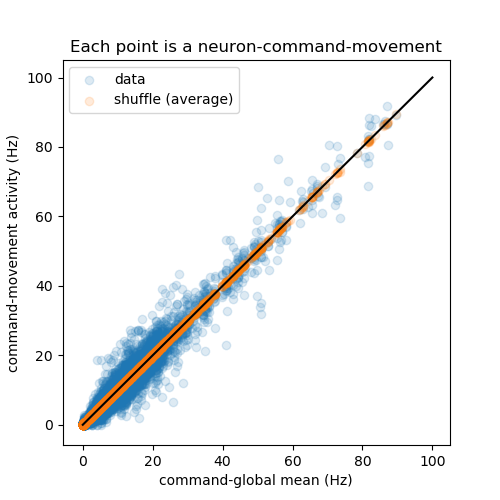

In [44]:
#Scatter: True vs Shuffle vs Global: 

fig_name = 'n_scatter_true_vs_shuffle_vs_global'
save_bool = False

sample_period=0.1
#ALL:
d = r.loc[:,'n_cm']/sample_period
s = r.loc[:,'n_s']/sample_period
g = r.loc[:,'n_c']/sample_period


plt.figure(figsize=(5,5))
plt.scatter(g,d,alpha=0.15, label='data')
plt.scatter(g,s,alpha=0.15, label='shuffle (average)')
plt.legend()

plt.plot([0, 100], [0,100],color='k')
plt.xlabel('command-global mean (Hz)')
plt.ylabel('command-movement activity (Hz)')
plt.title('Each point is a neuron-command-movement')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


<IPython.core.display.Javascript object>


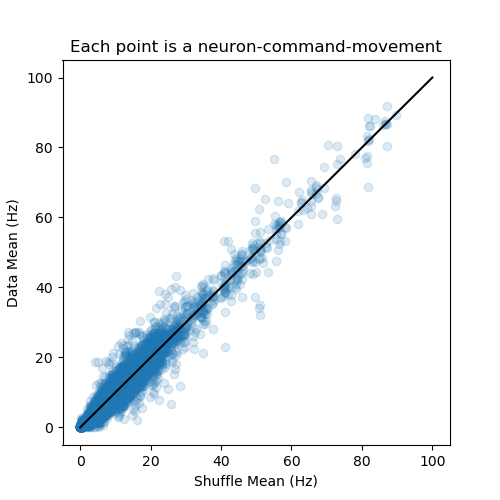

In [45]:
#Scatter: True vs Shuffle: 

fig_name = 'n_scatter_true_vs_shuffle'
save_bool = False

sample_period=0.1
#ALL:
d = r.loc[:,'n_cm']/sample_period
s = r.loc[:,'n_s']/sample_period


plt.figure(figsize=(5,5))
plt.scatter(s,d,alpha=0.15)

plt.plot([0, 100], [0,100],color='k')
plt.xlabel('Shuffle Mean (Hz)')
plt.ylabel('Data Mean (Hz)')
plt.title('Each point is a neuron-command-movement')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


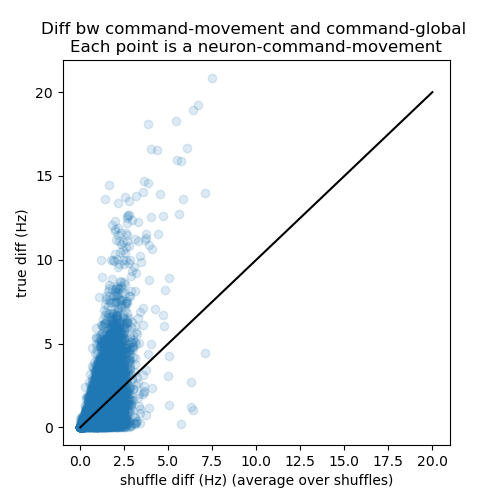

In [46]:
#Scatter Diff: True vs Shuffle: 

fig_name = 'n_diff_scatter_true_vs_shuffle'
save_bool = False

sample_period=0.1
#ALL:
d = r.loc[:,'abs_diff']/sample_period
s = r.loc[:,'abs_diff_s']/sample_period


plt.figure(figsize=(5,5))
plt.scatter(s,d,alpha=0.15)
plt.plot([0, 20], [0,20],color='k')
plt.xlabel('shuffle diff (Hz) (average over shuffles)')
plt.ylabel('true diff (Hz)')
plt.title('Diff bw command-movement and command-global \nEach point is a neuron-command-movement')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

#SIG:


<IPython.core.display.Javascript object>


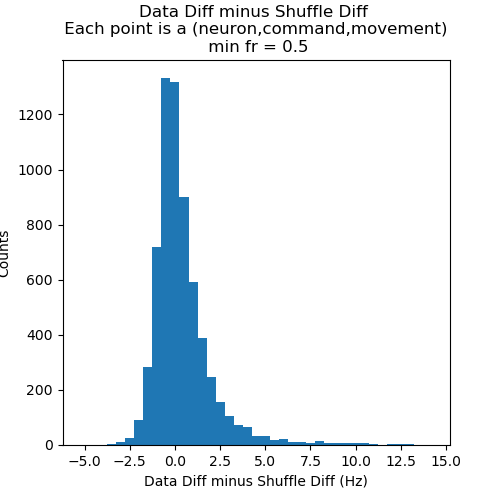

In [48]:
#Histogram the differences: 
fig_name='n_hist_data_diff_minus_shuffle_diff'
save_bool = False


sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
# sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr#&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

diff = d-s

bin_width=0.5
bin_e = np.arange(-5,15,bin_width)-bin_width/2
plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff, bin_e)
# plt.vlines(0,0,1.05*n.max())
plt.xlabel('Data Diff minus Shuffle Diff (Hz)')
plt.ylabel('Counts')
plt.title('Data Diff minus Shuffle Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
    

<IPython.core.display.Javascript object>


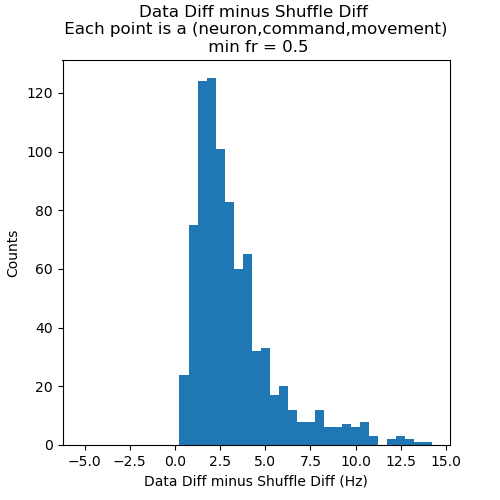

In [49]:
#Histogram the differences: 
fig_name='n_hist_data_diff_minus_shuffle_diff_SIG'
save_bool = False


sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

diff = d-s

bin_width=0.5
bin_e = np.arange(-5,15,bin_width)-bin_width/2
plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff, bin_e)
# plt.vlines(0,0,1.05*n.max())
plt.xlabel('Data Diff minus Shuffle Diff (Hz)')
plt.ylabel('Counts')
plt.title('Data Diff minus Shuffle Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
    

<IPython.core.display.Javascript object>


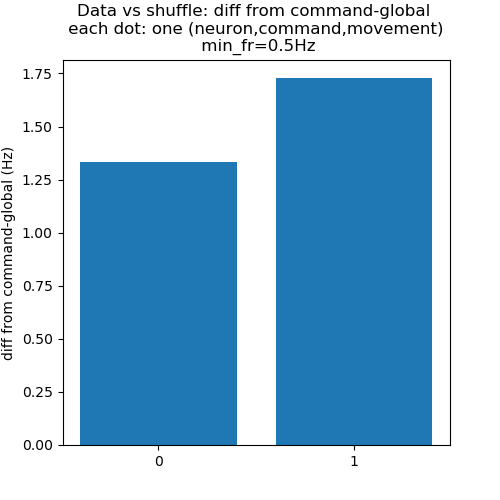

In [50]:
#Bar plot: 
#ALL

#Histogram the differences: 
fig_name='n_bar_data_diff_vs_shuffle_diff'
save_bool = False

sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
# sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr#&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

d_a = np.array(d)
s_a = np.array(s)
d_plt = np.concatenate((s_a.reshape(-1,1), d_a.reshape(-1,1)),axis=1).T

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])
plt.title('Data vs shuffle: diff from command-global \n each dot: one (neuron,command,movement) \n min_fr=0.5Hz')
_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])


plt.ylabel('diff from command-global (Hz)')
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


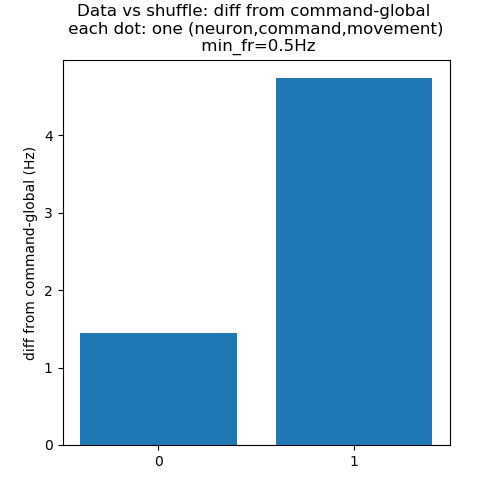

In [51]:
#Bar plot: 
#ALL

#Histogram the differences: 

save_bool = False
no_lines = True
if no_lines:
    fig_name='n_bar_data_diff_vs_shuffle_diff_SIG_no_lines'
else:
    fig_name='n_bar_data_diff_vs_shuffle_diff_SIG'



sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr&sel_sig
d = r.loc[sel,'abs_diff']/sample_period
s = r.loc[sel,'abs_diff_s']/sample_period

d_a = np.array(d)
s_a = np.array(s)
d_plt = np.concatenate((s_a.reshape(-1,1), d_a.reshape(-1,1)),axis=1).T

plt.figure(figsize=(5,5))

if not no_lines:
    _=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])
plt.title('Data vs shuffle: diff from command-global \n each dot: one (neuron,command,movement) \n min_fr=0.5Hz')
_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])


plt.ylabel('diff from command-global (Hz)')
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Individual neuron Frac Diff

<IPython.core.display.Javascript object>


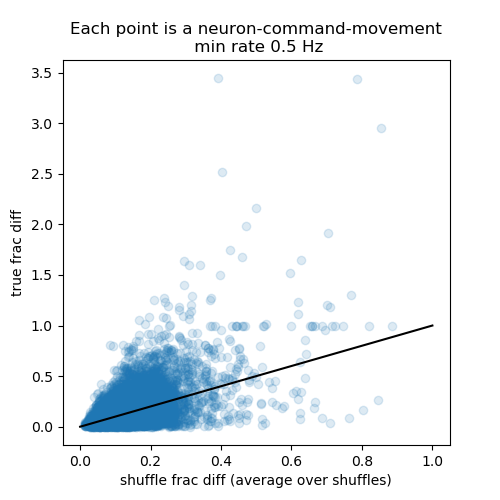

In [52]:
#Scatter Frac Diff: True vs Shuffle
#This doesn't look good for neurons with low mean rates:

fig_name = 'n_frac_diff_scatter_true_vs_shuffle'
save_bool = False

sample_period=0.1
#ALL:
min_fr = 0.5
sel = (r.loc[:,'n_c']/sample_period >= min_fr)
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']


plt.figure(figsize=(5,5))
plt.scatter(s,d,alpha=0.15)
plt.plot([0, 1.], [0,1],color='k')
plt.xlabel('shuffle frac diff (average over shuffles)')
plt.ylabel('true frac diff')
plt.title('Each point is a neuron-command-movement\n min rate 0.5 Hz')


if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

#SIG:

<IPython.core.display.Javascript object>


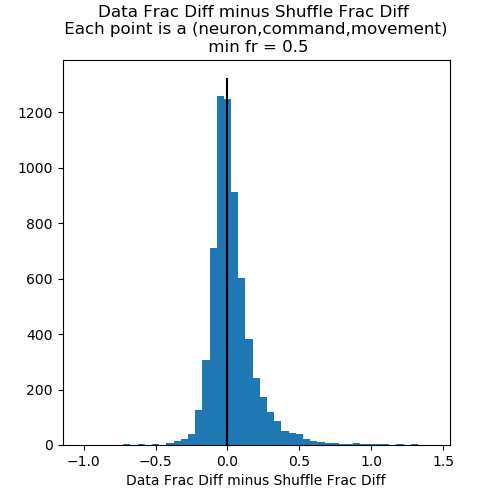

In [53]:
#Histogram of differences in frac diff: 
fig_name='n_hist_data_frac_diff_minus_shuffle_diff'
save_bool = False

sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
# sel_sig = (r.loc[:,'sig']==1)
sel = sel_min_fr#&sel_sig
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']
# d = r.loc[sel,'abs_diff']/sample_period
# s = r.loc[sel,'abs_diff_s']/sample_period
diff = d-s

bin_width=0.05
bin_e = np.arange(-1,1.5,bin_width)-bin_width/2

plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff, bin_e)
plt.vlines(0,0,1.05*n.max())
plt.xlabel('Data Frac Diff minus Shuffle Frac Diff')
# plt.ylabel('Counts')
plt.title('Data Frac Diff minus Shuffle Frac Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))


<IPython.core.display.Javascript object>


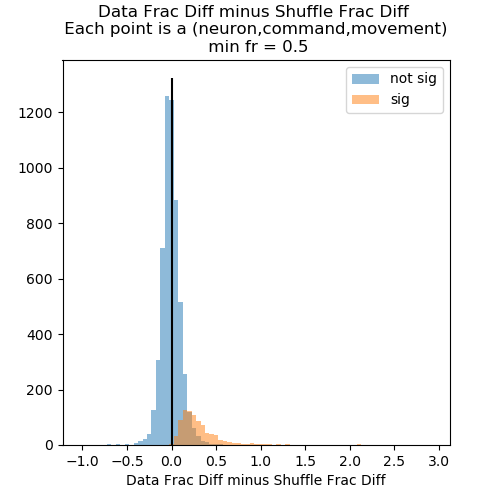

In [54]:
#Histogram of differences in frac diff: 
fig_name='n_hist_data_frac_diff_minus_shuffle_diff_SIG'
save_bool = False


sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)


sel = sel_min_fr&sel_sig
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']
diff_sig = d-s

sel = sel_min_fr&(~sel_sig)
d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']
diff_not_sig = d-s



bin_width=0.05
bin_e = np.arange(-1,3,bin_width)-bin_width/2
plt.figure(figsize=(5,5))
n,_,_=plt.hist(diff_not_sig, bin_e,alpha=0.5,label='not sig')
n_max = n.max()
n,_,_=plt.hist(diff_sig, bin_e,alpha=0.5,label='sig')
n_max = np.array([n_max, n.max()]).max()
plt.vlines(0,0,1.05*n_max)
plt.xlabel('Data Frac Diff minus Shuffle Frac Diff')
# plt.ylabel('Counts')
plt.title('Data Frac Diff minus Shuffle Frac Diff \n Each point is a (neuron,command,movement) \n min fr = 0.5')
plt.legend()

if save_bool: 
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))


n_bar_frac_diff_data_vs_shuffle_SIG_no_lines


<IPython.core.display.Javascript object>


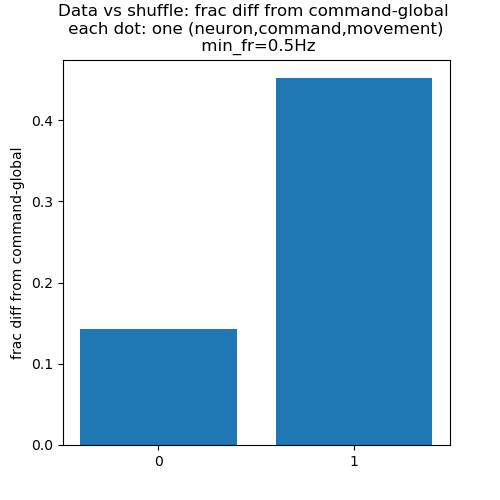

In [55]:
#BAR PLOT: 

save_bool = False
sig = True
no_lines = True
fig_name = 'n_bar_frac_diff_data_vs_shuffle'
if sig: 
    fig_name += '_SIG'
if no_lines:
    fig_name += '_no_lines'
print(fig_name)

sel_min_fr = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig = (r.loc[:,'sig']==1)

if sig:
    sel = sel_min_fr&sel_sig
else:
    sel = sel_min_fr

d = r.loc[sel,'frac_abs_diff']
s = r.loc[sel,'frac_abs_diff_s']

d_a = np.array(d)
s_a = np.array(s)
d_plt = np.concatenate((s_a.reshape(-1,1), d_a.reshape(-1,1)),axis=1).T

plt.figure(figsize=(5,5))

if not no_lines:
    _=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])
plt.title('Data vs shuffle: frac diff from command-global \n each dot: one (neuron,command,movement) \n min_fr=0.5Hz')
_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])


plt.ylabel('frac diff from command-global')
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


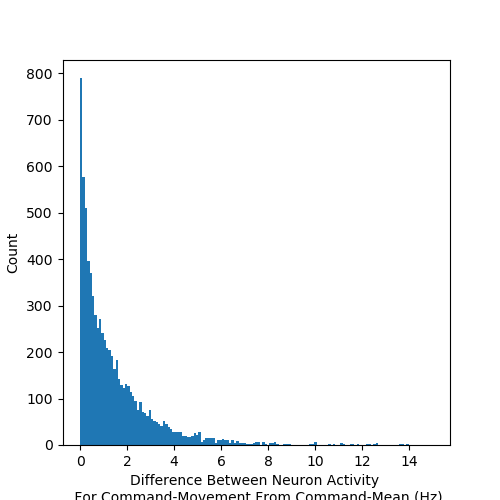

In [56]:
fig_name = 'hist_neuron_diff'
save_bool = False

bmi_sample_period = 0.1 #sec
bin_e = np.linspace(0,15,num=15*10,endpoint=True)

d = r.loc[:,'abs_diff']/bmi_sample_period
plt.figure(figsize=(5,5))
plt.hist(d, bins=bin_e)
plt.xlabel('Difference Between Neuron Activity \n For Command-Movement From Command-Mean (Hz)')
plt.ylabel('Count')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


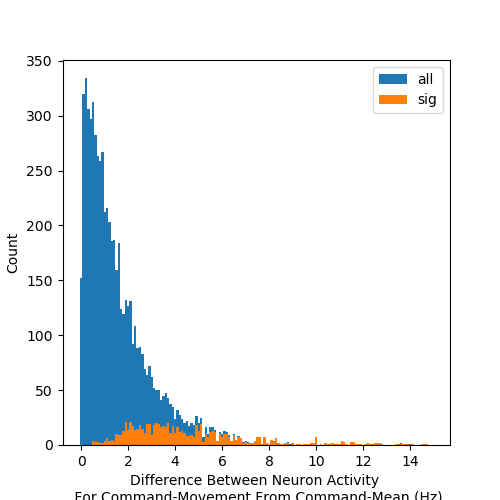

In [57]:
fig_name = 'hist_neuron_diff_all_vs_sig'
save_bool = False

sel_min_fr_ = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig_ = (r.loc[:,'sig']==1)

sel_all = sel_min_fr_
sel_sig = sel_min_fr_ & sel_sig_


d = r.loc[sel_all,'abs_diff']/bmi_sample_period
w_d = 1.0/len(d)*np.ones(len(d))

sig_sel = r.loc[:,'sig']==1
d_sig = r.loc[sel_sig,'abs_diff']/bmi_sample_period
w_d_sig = 1.0/len(d_sig)*np.ones(len(d_sig))


bmi_sample_period = 0.1 #sec
bin_e = np.linspace(0,15,num=15*10+1,endpoint=True)-0.05

plt.figure(figsize=(5,5))
plt.hist(d, bins=bin_e, label='all')
plt.hist(d_sig, bins=bin_e, label='sig') #alpha, weights



plt.legend()
plt.xlabel('Difference Between Neuron Activity \n For Command-Movement From Command-Mean (Hz)')
plt.ylabel('Count')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


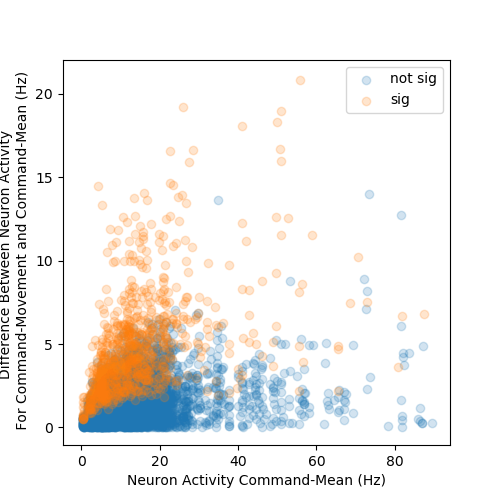

In [58]:
#Scatter command_mean vs diff

fig_name = 'scatter_neuron_command_mean_vs_diff'
save_bool = False
bin_sample_period = 0.1
alpha = 0.2

plt.figure(figsize=(5,5))

#not sig:
sel = sel_min_fr_&(~sel_sig_)
d_cm = r.loc[sel,'n_c']/bmi_sample_period
d_diff = r.loc[sel,'abs_diff']/bmi_sample_period
plt.scatter(d_cm, d_diff,alpha=alpha,label='not sig')

#sig:
sel_min_fr_ = (r.loc[:,'n_c']/sample_period >= min_fr)
sel_sig_ = (r.loc[:,'sig']==1)

sel = sel_min_fr_&sel_sig_
d_cm = r.loc[sel,'n_c']/bmi_sample_period
d_diff = r.loc[sel,'abs_diff']/bmi_sample_period

plt.scatter(d_cm, d_diff,alpha=alpha,label='sig')




plt.xlabel('Neuron Activity Command-Mean (Hz)')
plt.ylabel('Difference Between Neuron Activity \n For Command-Movement and Command-Mean (Hz)')
plt.legend()

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Plots for example command

In [64]:
cm_dic.keys()

[((1, 2), (3, 1.1), 'n_s'),
 ((0, 7), (6, 1.2), 'num_obs'),
 ((3, 4), (5, 1.2), 'p_n'),
 ((0, 5), (5, 1.2), 'p'),
 ((0, 2), (2, 1.1), 'num_obs'),
 ((1, 1), (4, 1.1), 'p'),
 ((3, 0), (6, 1.2), 'sel'),
 ((2, 7), (6, 1.1), 'num_sig_n'),
 ((2, 7), (7, 0), 'pool_match_idx'),
 ((0, 4), (2, 1.1), 'n_diff_norm_s'),
 ((3, 2), (5, 1.1), 'sel'),
 ((1, 3), (2, 0), 'n_diff_norm_s'),
 ((1, 4), (5, 1.1), 'num_obs'),
 ((3, 1), (7, 1.2), 'num_obs'),
 ((2, 4), (5, 1.2), 'pool_match_idx'),
 ((0, 0), (1, 1.1), 'pool_match_ttest'),
 ((1, 6), (4, 0), 'sel'),
 ((0, 5), (2, 0), 'sel'),
 ((3, 3), (7, 1.2), 'num_obs'),
 ((0, 5), (7, 1.2), 'sel'),
 ((1, 4), (5, 0), 'num_obs'),
 ((1, 6), (6, 1.1), 'sel'),
 ((3, 3), (4, 1.1), 'pool_match_success'),
 ((1, 5), (1, 1.2), 'sel'),
 ((3, 2), (2, 1.1), 'pool_match_idx'),
 ((2, 4), (4, 1.1), 'n_diff_norm_true'),
 ((2, 1), (1, 0), 'sel'),
 ((2, 5), (4, 0), 'shuffle_mat'),
 ((1, 0), (3, 1.1), 'pool_match_discard'),
 ((3, 1), (0, 1.1), 'pool_match_idx'),
 ((1, 2), (3, 0), 's

In [67]:
#This example was found in:
# 'neural_mean_diff_rel_shuffle_corr_behavior_dynamics_conditioning'

c = (0,2)
m_analyze = [(0, 1.1), (1, 0), (1, 1.1), (2, 0), (2, 1.1), (3, 1.1), (4, 1.1)]
num_m_analyze = len(m_analyze)
m = m_analyze[0]
# cm_dic[c,m,]

In [65]:
cm_dic[c,m,'mat_df'].shape

(117, 44)

In [70]:
cm_dic[c,m,'n_cm']

n_0     0.473684
n_1     0.315789
n_2     0.000000
n_3     0.052632
n_4     1.157895
n_5     1.631579
n_6     1.526316
n_7     0.315789
n_8     0.052632
n_9     0.000000
n_10    0.000000
n_11    2.421053
n_12    0.000000
n_13    0.105263
n_14    0.947368
n_15    1.157895
n_16    0.631579
n_17    0.368421
n_18    1.000000
n_19    0.315789
n_20    0.210526
n_21    1.000000
n_22    1.789474
n_23    2.052632
n_24    0.421053
n_25    0.894737
n_26    0.947368
n_27    0.736842
n_28    0.894737
n_29    1.052632
n_30    0.894737
n_31    3.421053
n_32    0.947368
n_33    0.578947
n_34    0.421053
n_35    0.421053
n_36    0.947368
n_37    0.842105
n_38    1.684211
n_39    0.578947
n_40    1.684211
n_41    2.315789
n_42    1.473684
n_43    0.526316
dtype: float64

In [75]:
#make a matrix of size: num_neurons X num_movements, which has the mean activity of each neuron
n_mat = np.zeros((num_neurons, num_m_analyze))
for i,m in enumerate(m_analyze): 
    n_mat[:,i] = cm_dic[c,m,'n_cm']
n_mat = n_mat/bmi_sample_period
    
    

<IPython.core.display.Javascript object>


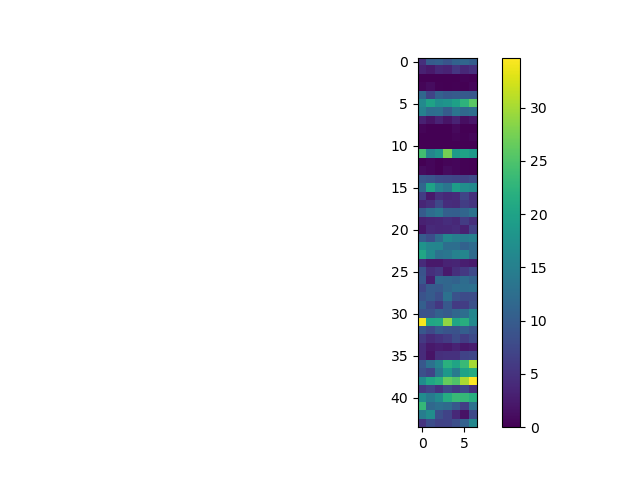

In [76]:
plt.figure()
plt.imshow(n_mat)
plt.colorbar()

In [187]:
#global_mean: 
cm_dic[c,'n_c'].shape

KeyError: ((0, 2), 'n_c')

<IPython.core.display.Javascript object>


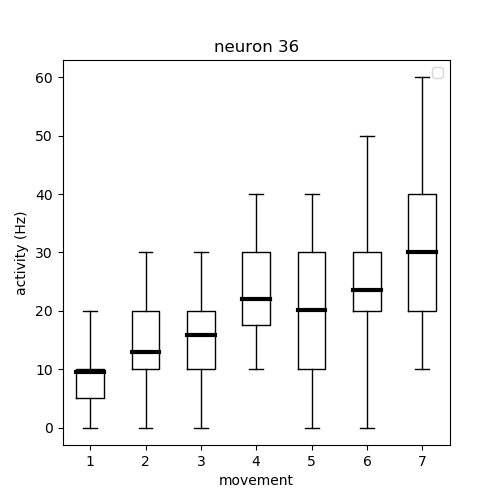

In [183]:
fig_name = 'ex_neuron_command_over_movements_boxplot'
save_bool = False

n_sel = 36
n_label = n_list[n_sel]
d_list = []
for m in m_analyze:
    d = np.array(cm_dic[c,m,'mat_df'].loc[:,n_label])
    d = d/bmi_sample_period
    d_list.append(d)

medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')
plt.figure(figsize=(5,5))
_=plt.boxplot(d_list,whis=[2.5,97.5], meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True

y=n_mat[n_sel,:]
# plt.plot(np.arange(num_m_analyze)+1, y, label='mean')
plt.legend()
plt.xlabel('movement')
plt.ylabel('activity (Hz)')
plt.title('neuron ' + str(n_sel))

if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))
        

<IPython.core.display.Javascript object>


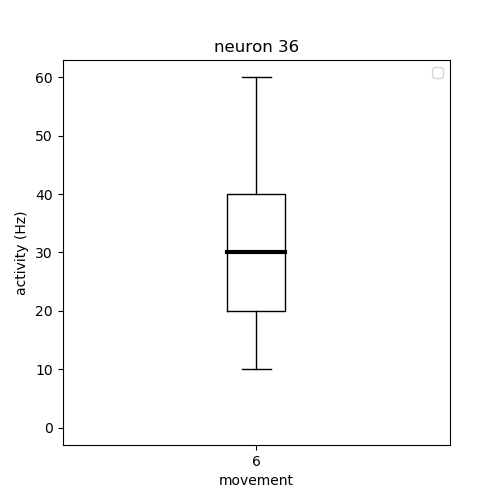

In [182]:
#Plot each box in the appropriate color
medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')
plt.figure(figsize=(5,5))
_=plt.boxplot(d,whis=[2.5,97.5], meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True

# y=n_mat[n_sel,:]
# plt.plot(np.arange(num_m_analyze)+1, y, label='mean')
plt.legend()
plt.xlabel('movement')
plt.ylabel('activity (Hz)')
plt.title('neuron ' + str(n_sel))

if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))

<IPython.core.display.Javascript object>


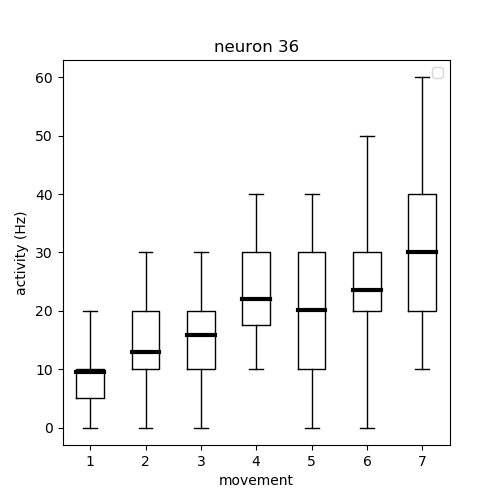

Text(0.5,1,'neuron 36')

<IPython.core.display.Javascript object>


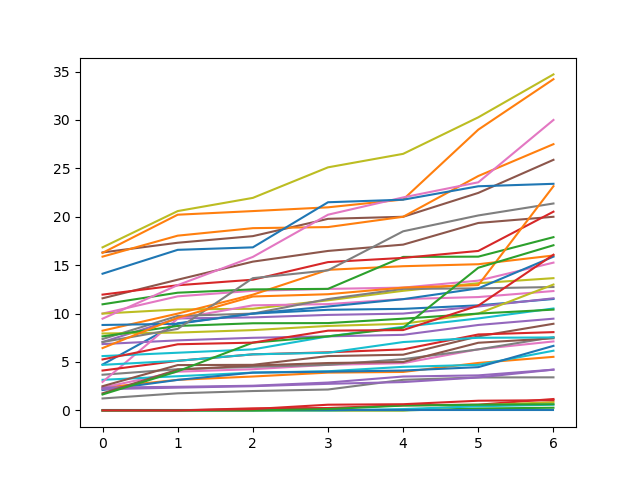

In [94]:
#just for visualization: 
ex_diff = []
ex_min = []
ex_max = []
plt.figure()
for i in range(num_neurons):
    y = n_mat[i,:]
    y = np.sort(y)
    plt.plot(y)
    
    ex_diff.append(y.max()-y.min())
    ex_min.append(y.min())
    ex_max.append(y.max())
ex_diff = np.array(ex_diff)    
ex_min = np.array(ex_min)    
ex_max = np.array(ex_max)    

In [101]:
ex_frac_diff = ex_diff/((ex_min+ex_max)/2)

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


In [89]:
np.argsort(ex_diff)

array([10,  2,  9, 12,  8, 13,  3, 24, 34,  7, 14, 32, 39, 19,  1, 18, 17,
       33,  4, 20, 16, 29, 28,  6, 27, 35, 25,  0, 22, 30, 21, 15, 23, 40,
       26,  5, 43, 11, 37, 42, 41, 38, 31, 36], dtype=int64)

In [114]:
m_analyze

[(0, 1.1), (1, 0), (1, 1.1), (2, 0), (2, 1.1), (3, 1.1), (4, 1.1)]

In [ ]:
#

<IPython.core.display.Javascript object>


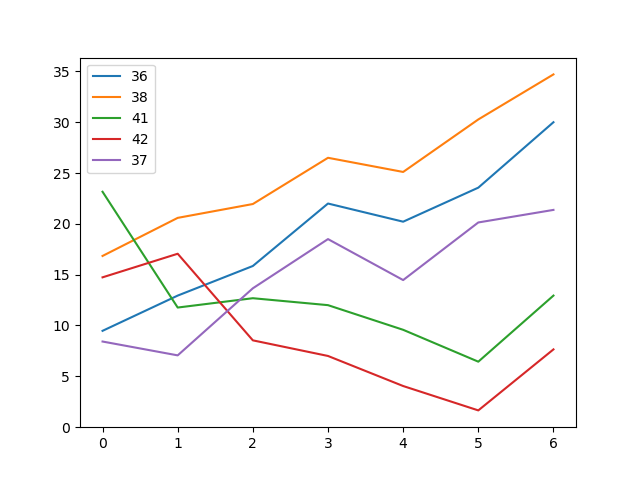

In [116]:
plot_list = [36,38,41,42,37]
plt.figure()
for i in plot_list:
    y = n_mat[i,:]
#     ys = np.sort(y)
    plt.plot(y, label=i)
    
plt.legend()

<IPython.core.display.Javascript object>


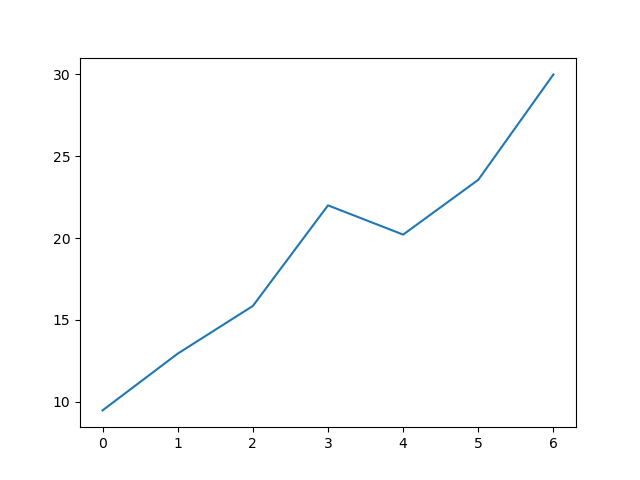

In [106]:
plt.figure()
plt.plot(n_mat[36,:])

In [87]:
ex_diff

[6.770007209805334,
 3.178973717146433,
 0.273972602739726,
 1.176470588235294,
 4.520123839009289,
 9.566563467492262,
 5.2631578947368425,
 2.181757434012696,
 0.8510638297872339,
 0.588235294117647,
 0.0,
 11.61764705882353,
 0.6382978723404255,
 1.0526315789473684,
 2.6243691420331654,
 8.421052631578947,
 4.770346494762288,
 3.8767650834403082,
 3.6585365853658534,
 3.0064888248017305,
 4.56140350877193,
 7.764705882352942,
 6.935832732516223,
 8.565531475748196,
 1.8575851393188856,
 6.447368421052632,
 9.387590652699435,
 5.3766769865841075,
 5.054794520547946,
 4.916559691912707,
 7.0588235294117645,
 17.936016511867905,
 2.7639000805801768,
 3.967459324155193,
 2.0187454938716654,
 5.686274509803922,
 20.526315789473685,
 14.313725490196077,
 17.86377708978328,
 2.82836422240129,
 9.286608260325405,
 16.719538572458546,
 15.414987912973409,
 10.815273477812177]

<IPython.core.display.Javascript object>


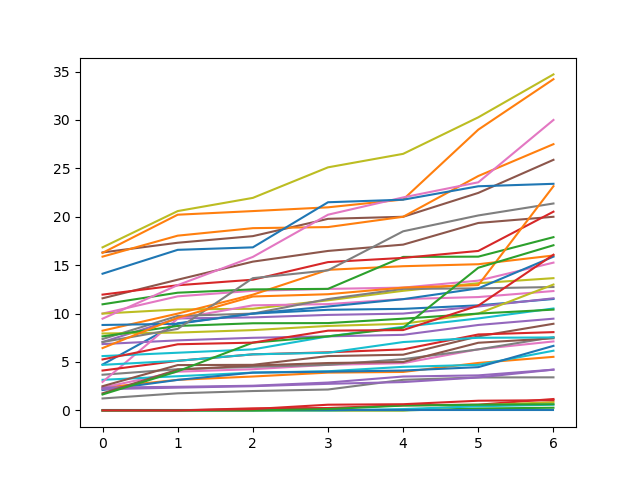

In [84]:
#just for visualization: 
plt.figure()
for i in range(num_neurons):
    y = n_mat[i,:]
    y = np.sort(y)
    plt.plot(y)

<IPython.core.display.Javascript object>


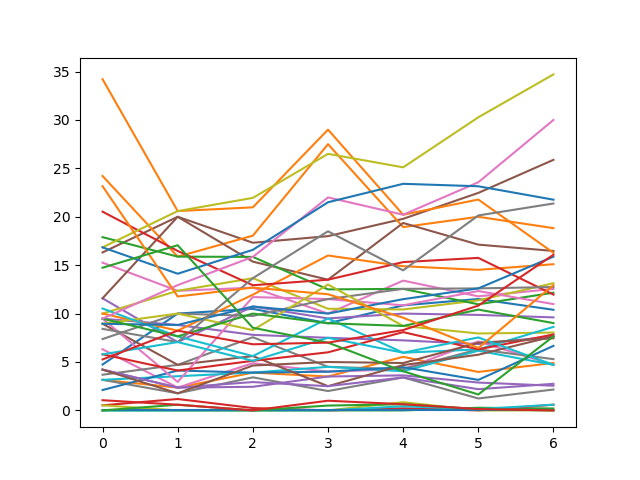

In [78]:
plt.figure()
_=plt.plot(n_mat.T)

In [63]:
r.head()

n_c      n_cm       n_s  abs_diff  frac_abs_diff      diff  \
0  1.041096  0.545455  1.044818  0.495641       0.476077  0.495641   
1  0.472603  0.500000  0.475227  0.027397       0.057971 -0.027397   
2  0.020548  0.000000  0.021455  0.020548       1.000000  0.020548   
3  0.027397  0.045455  0.028727  0.018057       0.659091 -0.018057   
4  1.095890  1.500000  1.092273  0.404110       0.368750 -0.404110   

   abs_diff_s  frac_abs_diff_s    diff_s  neuron  command_idx  movement_idx  \
0    0.176912         0.169928 -0.003722     0.0          0.0           1.0   
1    0.100551         0.212760 -0.002625     1.0          0.0           1.0   
2    0.025852         1.258121 -0.000907     2.0          0.0           1.0   
3    0.029220         1.066545 -0.001330     3.0          0.0           1.0   
4    0.164639         0.150233  0.003618     4.0          0.0           1.0   

   u_v_mag_bin  u_v_angle_bin  target  task_rot      p  sig  
0          0.0            0.0     0.0       1.1  0.029  1.0  
1          0.0            0.0     0.0       1.1  0.725  0.0  
2          0.0            0.0     0.0       1.1  0.393  0.0  
3          0.0            0.0     0.0       1.1  0.639  0.0  
4          0.0            0.0     0.0       1.1  0.053  0.0